Using the Northwind database, an open-source dataset created by Microsoft, this Jupyter notebook will do some exploratory data analysis and use hypothesis testing to dive deep into four questions:
1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?
2. Do discounts have a statistically significant effect on the dollar value of orders?
3. Do older customers have statistically significant larger value orders?
4. Do older customers have statistically significant larger order velocity (orders/time)?


Step 1: Import the libraries used.

In [1]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing

from datetime import datetime
# import warnings
# warnings.filterwarnings("ignore")

Step 2: Create an sqalchemy "engine" to query the database tables.

In [2]:
# create the SQL engine
# optinal - to use the large version of the databse, use this to create the SQL engine:
# engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# using the small version of the databse:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
con = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()

2019-05-15 13:01:42,154 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-15 13:01:42,156 INFO sqlalchemy.engine.base.Engine ()
2019-05-15 13:01:42,158 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-15 13:01:42,159 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# have a look at the various tables
inspector = inspect(engine)
print(inspector.get_table_names())

2019-05-15 13:01:50,523 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-15 13:01:50,525 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


There are 13 tables. This chart shows the relationships between the tables.
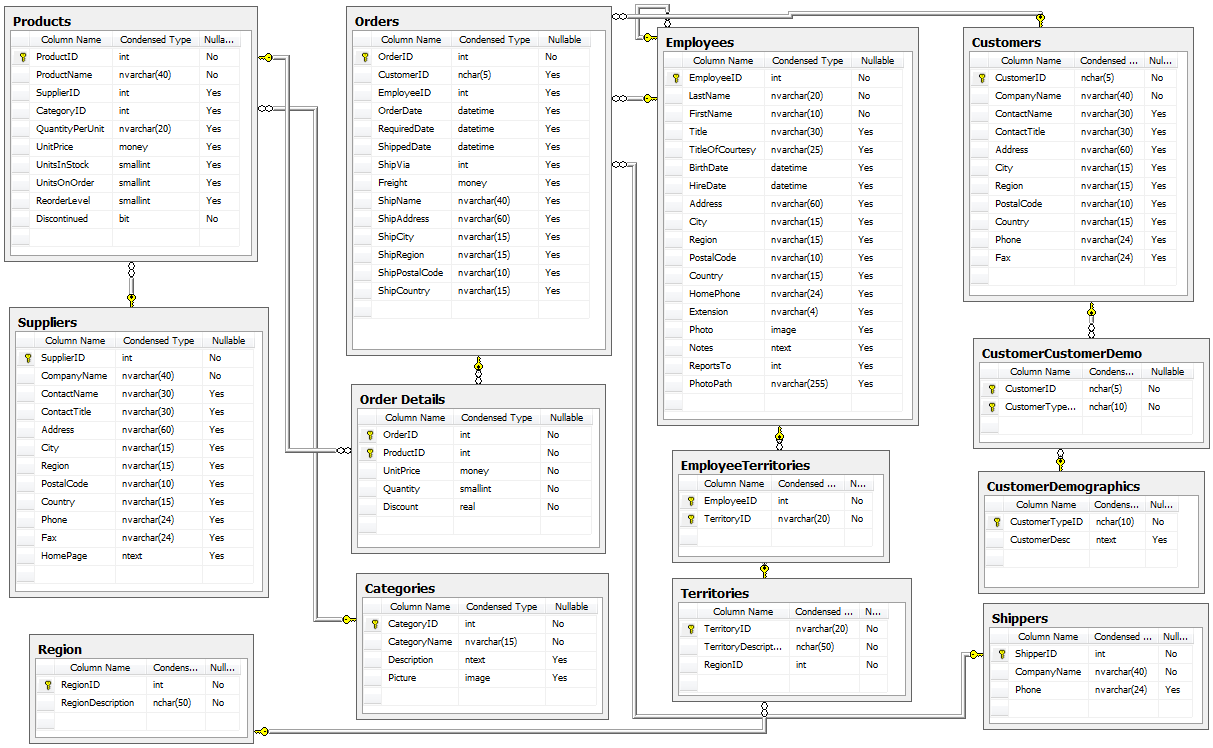

As I will be creating multiple pandas dataframes from the sql tables, I need a function that will return the column names from an SQL table.

In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

In [5]:
#function to return a list of the column names from table given as an argument
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols

In [6]:
# crate a pandas dataframe of the OrderDetail table
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-05-15 13:02:20,700 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-05-15 13:02:20,703 INFO sqlalchemy.engine.base.Engine ()
2019-05-15 13:02:20,719 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-15 13:02:20,720 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
# customer table to a pandas dataframe
rs = con.execute('SELECT * FROM Customer')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head(10)

2019-05-15 13:02:26,655 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-05-15 13:02:26,657 INFO sqlalchemy.engine.base.Engine ()
2019-05-15 13:02:26,665 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-05-15 13:02:26,666 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [8]:
# orders table to pandas datafarame
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names

orders.head()

2019-05-15 13:02:53,017 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-05-15 13:02:53,020 INFO sqlalchemy.engine.base.Engine ()
2019-05-15 13:02:53,031 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-05-15 13:02:53,033 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


After some errors during EDA I discovered some orders with CustomerId's that did not exist in the Customers table:
* ANTO
* DUMO
* OCEA
* QUEE

Upon inspection of the Customers table, it appears that the above Id's are all missing an "N" at the end of the Id. As customer Id's have 5 letters except these 4, so I chose to assign these orders to the what reasonably appears to be the correct Customer, assuming that the last letter had somehow been deleted. 

In [9]:
# correct the incorect CustomerId values in orders_count
orders['CustomerId'].replace('ANTO', 'ANTON', inplace=True)
orders['CustomerId'].replace('DUMO', 'DUMON', inplace=True)
orders['CustomerId'].replace('OCEA', 'OCEAN', inplace=True)
orders['CustomerId'].replace('QUEE', 'QUEEN', inplace=True)
orders.sort_values('CustomerId').groupby('CustomerId').groups

{'ALFKI': Int64Index([763, 444, 454, 587, 704, 395], dtype='int64'),
 'ANATR': Int64Index([511, 678, 377, 60], dtype='int64'),
 'ANTON': Int64Index([608, 117, 287, 325, 259, 434, 429], dtype='int64'),
 'AROUT': Int64Index([135, 520, 205, 616, 495, 310, 493, 459, 705, 768, 107, 672, 545], dtype='int64'),
 'BERGS': Int64Index([627, 406, 618, 676, 441, 485, 424, 378, 530, 609,  32, 276, 324,
              30, 197, 136, 196, 589],
            dtype='int64'),
 'BLAUS': Int64Index([366, 708, 261, 605, 334, 810, 253], dtype='int64'),
 'BLONP': Int64Index([112, 578, 49, 17, 311, 318, 336, 431, 201, 380, 188], dtype='int64'),
 'BOLID': Int64Index([78, 553, 722], dtype='int64'),
 'BONAP': Int64Index([ 83, 222, 692, 828,  92, 263, 114, 684, 415, 277, 579, 507, 484,
             623, 628, 467, 482],
            dtype='int64'),
 'BOTTM': Int64Index([162, 701, 696, 670, 800, 244, 494, 183, 727, 797, 734, 163, 779,
             141],
            dtype='int64'),
 'BSBEV': Int64Index([291, 290, 699, 23

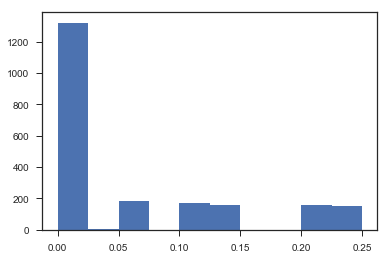

In [10]:
# an initial look at how product line items in the orders are distributed based on any discounts
plt.hist(order_detail["Discount"])
plt.show()

The vast majority of products ordered have no discount.
For ordered products that had a discount applied, the distribution into different levels of discount looks roughly equal.

The order_detail dataframe does not have any totals so I created a total for each line as that value would appear on the actual order.

In [11]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [12]:
# a little more EDA, how many orders had at least one product discounted?
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()

2019-05-15 13:04:09,011 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-05-15 13:04:09,013 INFO sqlalchemy.engine.base.Engine ()


Id    380
dtype: int64

380 orders had at least one discounted product. How many orders had no discounts?

In [13]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

orders_without_discount.count()

Id                450
CustomerId        450
EmployeeId        450
OrderDate         450
RequiredDate      450
ShippedDate       440
ShipVia           450
Freight           450
ShipName          450
ShipAddress       450
ShipCity          450
ShipRegion        450
ShipPostalCode    446
ShipCountry       450
_merge            450
dtype: int64

450 orders had no discounted items. Just to check the totals, I checked the total number of orders.

In [14]:
len(orders)

830

450 orders with no discount plus 380 orders that had a discount equals 830 total orders. Now checking for any missing values in the orders table. 

In [15]:
orders.count()

Id                830
CustomerId        830
EmployeeId        830
OrderDate         830
RequiredDate      830
ShippedDate       809
ShipVia           830
Freight           830
ShipName          830
ShipAddress       830
ShipCity          830
ShipRegion        830
ShipPostalCode    811
ShipCountry       830
dtype: int64

* 19 orders have no value for ShipPostalCode.
* 21 orders have no value for ShippedDate.

To investigate the first question:

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**

I added four new columns to the orders table:
* order_total
* unique_products_count
* all_items_total_qty_count
* discount_flag


In [16]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0
orders['discount_flag'] = False #True if order contains any discounted items, otherwise False

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0,False
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0,False
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0,False


In [17]:
# populate the new columns

for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index = index
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
    
    #clear the variables
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    discount_flag = False
    
    # iterate through the order_detail rows and calculate the values
    for index, row in temp_df.iterrows():
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        product_ids.append(row['ProductId'])  #get the unique product id's
        all_items_total_qty_count += row['Quantity'] #count up the total # of units of all products in the order

    #check if any discount, if yes skip for this row, otherwise check if the current row has a discount
        if discount_flag == False:
            if row['Discount'] > 0:
                discount_flag = True
    
    product_ids = set(product_ids)     #make a set (unique values only) of the product id's
    
# add these values to the order in the orders dataframe
    orders.iloc[order_index, orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index, orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index, orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    orders.iloc[order_index, orders.columns.get_loc('discount_flag')] = discount_flag


In [18]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


I then split the orders table into two tables, one for orders with a discount and one for orders without a discount and checked to make sure the length of the tables matched the original SQL tables.


In [19]:
discount = orders[orders['discount_flag'] == True].copy()
len(discount)

380

In [20]:
no_discount = orders[orders['discount_flag'] == False].copy()
len(no_discount)

450

I wanted to first look at a scatter plot comparing orders with and without a discount.

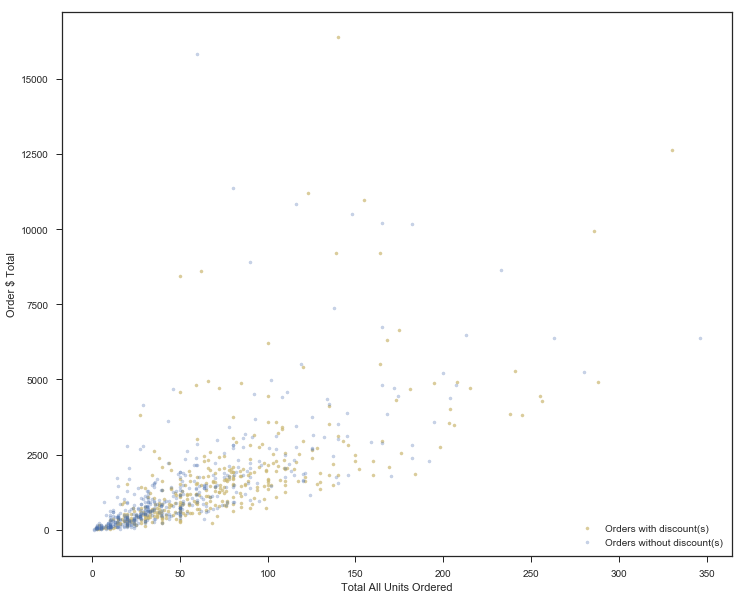

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(discount['all_items_total_qty_count'], discount['order_total'], s=10, c='y', alpha=.7, label='Orders with discount(s)')
ax.scatter(no_discount['all_items_total_qty_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Total All Units Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='lower right')

There does appear to be a correlation where orders wtih a discount tend to have a higher total units ordered. To investigate further, I need to look at the level of discount present. To do this I will need to look at the order_details table.

I could take each product in of the order_detail table and calculate the average units ordered per each level of discount. Much harder would be to do this for each individual product.

In [24]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


Assign each product line item to one of four discount groups:
* 1 = discount less than 5% or no discount
* 2 = discount equal to or greater than 5% but less than 10%
* 3 = discount equal to or greater than 10% but less than 20%
* 4 = discount equal to or greater than 20%

In [25]:
#create the new column and fill it with zero's
order_detail['discount_group'] = 0

#iterate through the dataframe and assign each line to the correct group
for index, row in order_detail.iterrows():
#     x = order_detail.columns.get_loc('discount_group')
#     print(x)
#     break
    if row['Discount'] < 0.05:
        order_detail.iloc[index, 7] = 1
    if row['Discount'] >= 0.05 and row['Discount'] < 0.10:
        order_detail.iloc[index, 7] = 2
    if row['Discount'] >= .1 and row['Discount'] < 0.2:
        order_detail.iloc[index, 7] = 3
    if row['Discount'] >= 0.2:
        order_detail.iloc[index, 7] = 4


In [26]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,1
1,10248/42,10248,42,9.8,10,0.0,98.0,1
2,10248/72,10248,72,34.8,5,0.0,174.0,1
3,10249/14,10249,14,18.6,9,0.0,167.4,1
4,10249/51,10249,51,42.4,40,0.0,1696.0,1


In [27]:
grouped = order_detail.groupby('discount_group')
print (grouped['Quantity'].agg(np.mean))


discount_group
1    21.609517
2    27.870968
3    26.733333
4    27.619048
Name: Quantity, dtype: float64


It appears that orders with a discount have a significantly higher mean quantity ordered than orders with a discount less than 5%


In [31]:
print(grouped['line_total'].agg(np.mean))

discount_group
1    567.210544
2    793.985454
3    542.440342
4    597.205306
Name: line_total, dtype: float64


Orders with a discounts in category 2 and 4 have higher mean quantity ordered than orders in groups 1 and 3.

Make a scatter chart to further explore these relationships.


In [32]:
# make discount_group a categorical daya type
order_detail['discount_group'] = pd.Categorical(order_detail['discount_group'])
print (order_detail.dtypes)

Id                  object
OrderId              int64
ProductId            int64
UnitPrice          float64
Quantity             int64
Discount           float64
line_total         float64
discount_group    category
dtype: object


In [33]:
temp = [('1',21.609517),('2',27.870968),('3',26.733333),('4',27.619048)]
temp_df = pd.DataFrame(temp, columns=['discount_group', 'mean_quantity'])
temp_df.head()

,discount_group,mean_quantity
0,1,21.609517
1,2,27.870968
2,3,26.733333
3,4,27.619048


<BarContainer object of 4 artists>

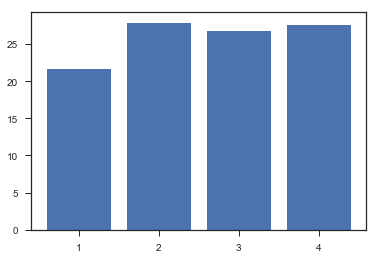

In [34]:
plt.bar(x='discount_group', height='mean_quantity', data=temp_df, align='center')

The average quantity ordered appears to be similarly higher for each category of discount, as compared to products with a less than 5% discount.

<BarContainer object of 4 artists>

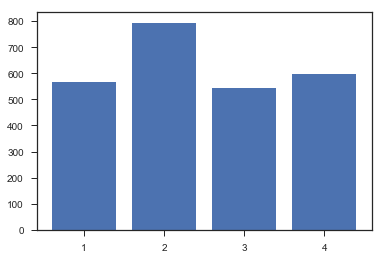

In [35]:
# bar chart of line_total by discount_category
temp = [('1',567.210544),('2',793.985454),('3',542.440342),('4',597.205306)]
temp_df = pd.DataFrame(temp, columns=['discount_group', 'line_total'])
# temp_df.head()
plt.bar(x='discount_group', height='line_total', data=temp_df, align='center')

It looks like products ordered with a discount_category of 2 generate the largest mean dollar amount.

Discount category 2 = discounts of at least 5% but less than 10%.

In [36]:
# make a temp dataframe of only the rows with a discount of 5% or more
temp_df = order_detail[order_detail['discount_group'] != 1].copy()
temp_df.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
6,10250/51,10250,51,42.4,35,0.15,1261.40,3
7,10250/65,10250,65,16.8,15,0.15,214.20,3
8,10251/22,10251,22,16.8,6,0.05,95.76,2
9,10251/57,10251,57,15.6,15,0.05,222.30,2
11,10252/20,10252,20,64.8,40,0.05,2462.40,2


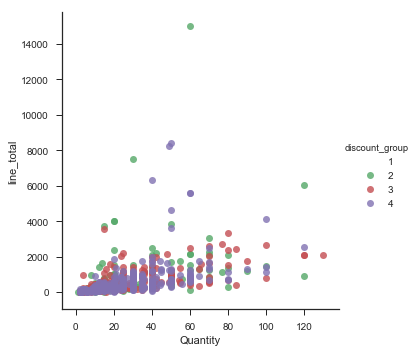

In [37]:
sns.lmplot('Quantity', 'line_total', data=temp_df, hue='discount_group', fit_reg=False)

In [38]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,1
1,10248/42,10248,42,9.8,10,0.0,98.0,1
2,10248/72,10248,72,34.8,5,0.0,174.0,1
3,10249/14,10249,14,18.6,9,0.0,167.4,1
4,10249/51,10249,51,42.4,40,0.0,1696.0,1


Hypothesis test #1:

Ho: There is no difference in the mean quantity ordered of products with a discount of 5% or more as compared to with a discount of less than 5%.

Ha: The mean quantity of products ordered with a discount of 5% or more is higher than products ordered with a discount of less than 5%.

In [115]:
mean_with_discount = np.mean(order_detail[order_detail['Discount'] >= 0.05]['Quantity'])
mean_with_discount

27.323706377858002

In [116]:
# get the number of rows that have a discount of 5% or greater
len(order_detail[order_detail['Discount'] >= 0.05])


831

In [117]:
mean_without_discount = np.mean(order_detail[order_detail['Discount'] < 0.05]['Quantity'])
mean_without_discount

21.6095166163142

In [118]:
# get the numer of rows that have a discount less than 0.05
len(order_detail[order_detail['Discount'] < 0.05])

1324

In [119]:
len(order_detail)

2155

In [120]:
actual_difference = mean_with_discount - mean_without_discount
actual_difference

5.714189761543803

In [121]:
def permutation_samples(key_value_list, no_of_trials, sample_size, column):
    difference_of_means = []

    while len(difference_of_means) < no_of_trials:
        temp_keys = key_value_list.index.values
        treatment_keys = np.random.choice(temp_keys, sample_size, replace=False)

        treatment = key_value_list[key_value_list.index.isin(treatment_keys)]
        control = key_value_list[~key_value_list.index.isin(treatment_keys)]

        # actual difference, positive or negative
        difference = np.mean(treatment[column]) -  np.mean(control[column])
        difference_of_means.append(difference)

#         print('difference value added:', abs_difference)
    return(difference_of_means)

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


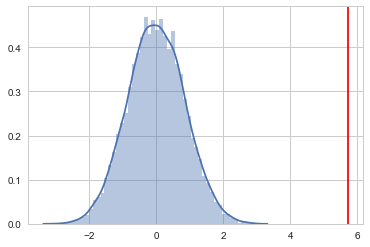

In [122]:
#run 10,000 samples of size 831 from the order_detail table. For each of the 10,000
# trials, calculate the difference in the mean between the 831 chosen, and the remaining
# rows not choses. The resulting list of 10,000 values is the difference in the mean
# each time. Then look at a distribution plot and place a red line where the actual mean
# difference was observed between the two groups.

number_of_trials = 10000
treatment_size = 831
permutation_list = permutation_samples(order_detail, number_of_trials, treatment_size, 'Quantity')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [128]:
# calculate the p-value 
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > actual_difference)
p_value = count/number_of_trials

print('P-value: {:.12e}'.format(p_value))

P-value: 0.000000000000e+00


Clearly the observed mean difference of the quantity ordered between products with a discount and without a discount is extremely unlikely to be from chance. The null hypothsis can be rejected. But how is the level of discount effecting the mean quantity ordered?

In [83]:
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total,discount_group
0,10248/11,10248,11,14.0,12,0.0,168.0,1
1,10248/42,10248,42,9.8,10,0.0,98.0,1
2,10248/72,10248,72,34.8,5,0.0,174.0,1
3,10249/14,10249,14,18.6,9,0.0,167.4,1
4,10249/51,10249,51,42.4,40,0.0,1696.0,1


In [105]:
# make a subset of order_detail records for each of the levels of discount. 
# Do some EDA on these three groups.
temp_df = order_detail.loc[order_detail['discount_group'] != [1],['OrderId','discount_group','Quantity', 'line_total']].copy()
temp_df.head()

,OrderId,discount_group,Quantity,line_total
6,10250,3,35,1261.40
7,10250,3,15,214.20
8,10251,2,6,95.76
9,10251,2,15,222.30
11,10252,2,40,2462.40


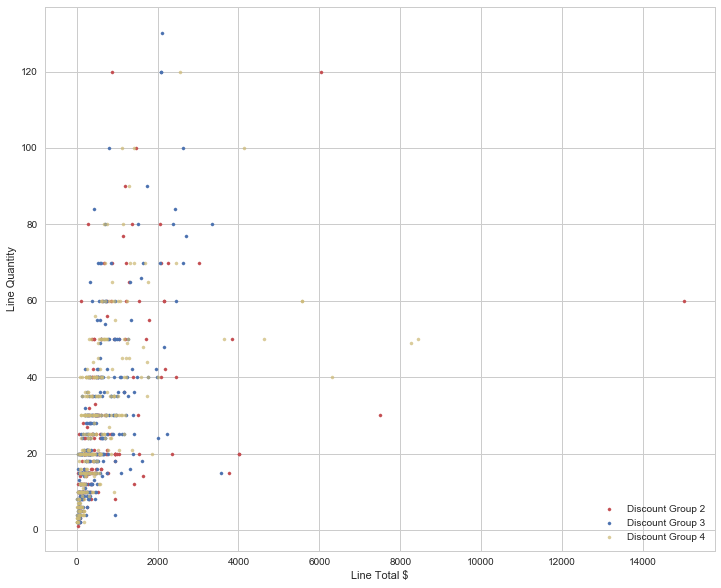

In [112]:
# plot these rows, color to indicate disocunt_group
fig, ax = plt.subplots(figsize=(12, 10))
temp_2 = temp_df.loc[temp_df['discount_group'] == 2]
temp_3 = temp_df.loc[temp_df['discount_group'] == 3]
temp_4 = temp_df.loc[temp_df['discount_group'] == 4]

ax.scatter(temp_2['line_total'], temp_2['Quantity'], s=10, c='r', alpha=1, label='Discount Group 2')
ax.scatter(temp_3['line_total'], temp_3['Quantity'], s=10, c='b', alpha=1, label='Discount Group 3')
ax.scatter(temp_4['line_total'], temp_4['Quantity'], s=10, c='y', alpha=.7, label='Discount Group 4')

ax.set_xlabel("Line Total $")
ax.set_ylabel("Line Quantity")
plt.legend(loc='lower right')

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


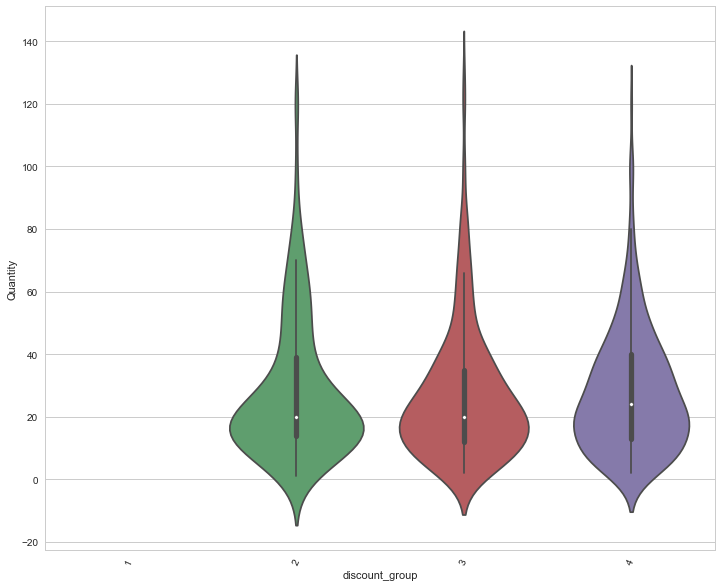

In [129]:
# try a violin plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

ax = sns.violinplot(x='discount_group', y='Quantity', data=temp_df)
plt.xticks(rotation=65)
plt.show()

There does not appear to be a substantial difference in the quantity ordered among the different discount groups.
Since there is a signifigant difference between quantity ordered when there is no disocunt vs. discounts of 5% or more, it may be worthwhile to test only offering discounts of 5% and see how it changes. 

In [73]:
# I think this was in error - any distribution of sample means will be normally distributed.
# stats.normaltest(permutation_list)


The normality test of my permutation samples yeilds a p-value 0.81.
In this test, the null hypothesis is that the sample came from a normally distributed population. The high p-value indicates that the null hypothesis cannot be rejected, or more plainly, the sample is likely coming from a normally distributed population.

/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


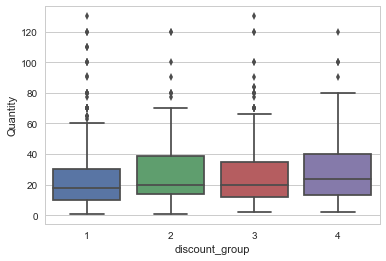

In [74]:
# look at bar charts of discount levels
sns.set_style("whitegrid") 
  
sns.boxplot(x = 'discount_group', y = 'Quantity', data = order_detail)


/Users/giovanni/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


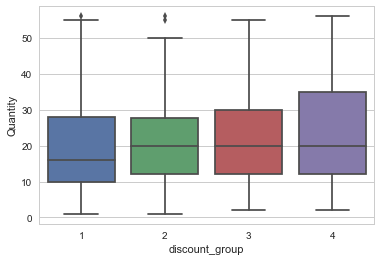

In [75]:
#there are many outliers in all discount_groups. I chose to eliminate all outliers at the top 5% of values.
quantile = order_detail['Quantity'].quantile(0.95)
temp_df = order_detail[order_detail['Quantity'] < quantile]
sns.boxplot(x = 'discount_group', y = 'Quantity', data = temp_df)

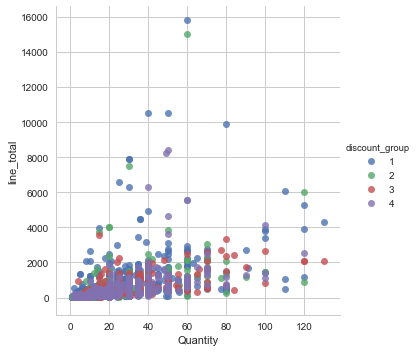

In [76]:
sns.lmplot( x='Quantity', y='line_total', data=order_detail, fit_reg=False, hue='discount_group', legend=True)
 


There does not appear to be a large difference in the quantity of products ordered, when comparing discounts of 5% and higher.

Hypothesis test #2:

Ho: There is no difference in the dollar amount ordered of products with a discount of 5% or more as compared to with a discount of less than 5%.

Ha: The mean dollar amount of products ordered with a discount of 5% or more is higher than products ordered with a discount of less than 5%.

In [77]:
mean_with_discount = np.mean(order_detail[order_detail['Discount'] >= 0.05]['line_total'])
mean_with_discount

619.5021407942237

From my analysis above I know there are 831 lines that match this criteria.
Now look at the mean line total for the lines with a discount of less than 5%.


In [78]:
mean_without_discount = np.mean(order_detail[order_detail['Discount'] < 0.05]['line_total'])
mean_without_discount

567.2105441842901

Again from above, I know there are 1,324 lines with a discount of less than 5%. After calculating the actual difference between these two groups, I will run another test using permutations to see how likely it is to get the difference observed.

In [79]:
actual_difference = mean_with_discount - mean_without_discount
actual_difference

52.29159660993355

/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


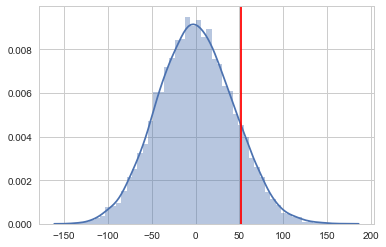

In [80]:
permutation_list = permutation_samples(order_detail, number_of_trials, treatment_size, 'line_total')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [81]:
# calculate the p-value for 
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > actual_difference)
p_value = count/number_of_trials
p_value

0.1165

*** START HERE ***
need to reorder the box plots & violin plots

Out of 10,000 random samples of size 831, 1,165 had a difference of more than 52.29. 
There is an 11.58% chance that these results could have been obtained randomly. 
I cannot reject the null hypothesis. Besause the data set does not include product costs, I have no way of evaluating the how discounts effect profit margins or dollar amounts of a product. With that information further analysis could be done to better understand the financial impact of various levels of discount on each product. 

Hypothesis test #3:

Ho: There is no difference in the average order dollar amount for the oldest 50% of customers as compared to the youngest 50% of customers.

Ha: The average order dollar amount for the oldest 50% of customers is larger as compared to the youngest 50% of customers.

I added five new columns to the customers table:
    * total number of orders
    * total $ value of all orders
    * first order date
    * last order date
    * average orders/month (year?, etc.)


In [ ]:
# add columns to customer dataframe: orders_count, orders_value, first_order_date, last_order_date
customers['orders_count'] = 0
customers['orders_value'] = 0
customers['order_avg'] = 0
customers['first_order_date'] = 0
customers['last_order_date'] = 0

# cast date columns as pandas datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers.head()


In [ ]:
#get orders count
orders_count = orders.groupby("CustomerId")["Id"].nunique()
orders_count.head(10)

In [ ]:
orders_count = orders_count.reset_index()
# orders_count.describe()
orders_count.head(10)

In [ ]:
orders_count.rename(columns={'Id':'order_count'}, inplace=True)
orders_count.head()

In [ ]:
orders_count.describe()

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(orders_count['order_count'], color="blue",)
plt.title("Distribution of the Number of Orders per Customer")

In [ ]:
# add order count to each customer record

for index, row in orders_count.iterrows():
    customer_id = row['CustomerId']
    order_count = row['order_count']
    customer_index = "NONE"
    
    # all customer id's in the customer table had five digits
    # this if/else statement was used to identify orders where the customer id was not five digits long
    if len(customer_id) == 5:                               
        customer_index = customers.loc[customers['Id'] == customer_id].index
        customers.iloc[customer_index, customers.columns.get_loc('orders_count')] = order_count
    else:
        print('CustomerId: {}'.format(customer_id))
        print('Order Count: {}'.format(order_count))
        print('Customer Index: {}'.format(customer_index))

In [ ]:
#calculate customers total value of all orders
orders_total = orders.groupby("CustomerId")['order_total'].agg(sum)

orders_total = orders_total.reset_index()
orders_total.head()

In [ ]:
# add the total value of all orders to each customer
for index, row in orders_total.iterrows():
    customer_id = row['CustomerId']
    order_total = row['order_total']
    customer_index = customers.loc[customers['Id'] == customer_id].index
    customers.iloc[customer_index,customers.columns.get_loc('orders_value')] = order_total

In [ ]:
customers.head(10)

In [ ]:
customers.describe()

In [ ]:
# inspect the count of orders for customers

order_counts = customers.groupby('orders_count')['orders_count'].count()
order_counts

Two customers have no order, one customer has only one order.

In [ ]:
under_two_orders = customers.loc[customers['orders_count'] < 2]
print (under_two_orders)

In [ ]:
#get first and last order dates
# order_dates = orders.groupby("CustomerId")['OrderDate']

for index, row in customers.iterrows():
    #iterrate through customers list
    #set first and last order date variables, cast as time_date
    first_order_date = np.NaN
    last_order_date = np.NaN
    first_order_date = pd.to_datetime(first_order_date)
    last_order_date = pd.to_datetime(last_order_date)

    # get current customer id
    customer_id = row['Id']
    temp_list = []
    # iterrate through orders
    for index, row in orders.iterrows():
        if row['CustomerId'] == customer_id:
            temp_list.append(row['OrderDate'])
#     print(temp_list)
    temp_list.sort()
    customer_index = customers.loc[customers['Id'] == customer_id].index
    
    if len(temp_list) == 0: #flag to see if any customers have no orders
        print('No order found for customer: {}'.format(customer_id))
        
    if len(temp_list) == 1: #handle the case where there is only one order
        print('Customer: {} has only one order.'.format(customer_id))
        temp_date = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_date
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_date
        
    if temp_list: # case there there is more than one order
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_list.pop(-1)
    

In [ ]:
customers.head()

In [ ]:
# create some columns: average value of each customers orders, age of customer
# cast date columns as datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers['order_avg'] = customers['orders_value'] / customers['orders_count']
today = pd.to_datetime('today')
customers['scaled_customer_age'] = (today - customers['first_order_date']).dt.days

customers.sort_values(['scaled_customer_age'])

In [ ]:
# normalize customer_age
x = customers[['scaled_customer_age']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

customers['scaled_customer_age'] = x_scaled


# https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/

In [ ]:
customers.head()

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(customers['scaled_customer_age'], color="blue",)
plt.title("Distribution of scaled_customer_age")

In [ ]:
# look at the outliers
temp = customers.loc[customers['orders_count'] < 4]
temp.head(10)

In [ ]:
#drop customers with less than 2 orders - only one
customers_temp = customers.loc[customers['orders_count'] > 1]
len(customers_temp)

In [ ]:
# re-normalize customer_age
x = customers_temp[['scaled_customer_age']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

# customers_temp['scaled_customer_age'] = x_scaled
customers_temp.loc[:,'scaled_customer_age'] = x_scaled

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(customers_temp['scaled_customer_age'], color="blue",)
plt.title("Distribution of scaled_customer_age")

In [ ]:
plt.scatter(customers_temp.scaled_customer_age, customers_temp.order_avg)

There appears to be a correlation between the age of a customer and their average order dollar size. For hypothesis test, I'll get the average order dollar amount for "older" customers and compare that to "younger" customers. Older and younger are based on how long ago the customer made their first order. I will look at some different slicing points to seperate the two groups.

In [ ]:
customers_temp.describe()

The oldest 25% of customers (with more than 3 orders) have a scaled_customer_age of 0.033605 or greater.
I want a more complete list of percentile values:


In [ ]:
customers_temp['scaled_customer_age'].quantile([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

The oldest 10% of customers have a scaled_customer_age of .034921 or more.

In [ ]:
customers_temp['oldest_50pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.833624, True, False)
customers_temp['oldest_25pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.939460, True, False)
customers_temp['oldest_10pct'] = np.where(customers_temp['scaled_customer_age'] >= 0.977875, True, False)
customers_temp.sort_values(['scaled_customer_age'])

In [ ]:
#get count of the oldest 50% of customers
len(customers_temp[customers_temp['oldest_50pct'] == True])

In [ ]:
#get count of the oldest 25% of customers
len(customers_temp[customers_temp['oldest_25pct'] == True])

In [ ]:
#get count of the oldest 10% of customers
len(customers_temp[customers_temp['oldest_10pct'] == True])

In [ ]:
# look at the difference between mean order amounts - divide at 50%
control_mean = np.mean(customers_temp[customers_temp['oldest_50pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_50pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

In [ ]:
permutation_list = permutation_samples(customers_temp, 10000, 44, 'order_avg')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [ ]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 222.74)
p_value = count/10000
print('P-value:', p_value)

In [ ]:
# look at the difference between mean order amounts - divide at oldest 25%
control_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

In [ ]:
permutation_list = permutation_samples(customers_temp, 10000, 20, 'order_avg')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [ ]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 578.32)
p_value = count/10000
print('P-value:', p_value)

In [ ]:
# look at the difference between mean order amounts - divide at oldest 10%
control_mean = np.mean(customers_temp[customers_temp['oldest_10pct'] == False]['order_avg'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_10pct'] == True]['order_avg'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

In [ ]:
permutation_list = permutation_samples(customers_temp, 10000, 8, 'order_avg')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [ ]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > 88.84)
p_value = count/10000
print('P-value:', p_value)

Conclusions:
Probability that the observed difference in average order amount for each group compared to it's complement:
* 2.4% for the oldest 50%
* 0.38% for the oldest 25%
* 36.6% for the oldest 10%
 
Using a p-value of 0.05 (5%) for statistical signifigance:
With respect to the oldest 1/2 and oldest 1/4 of customers, the null hypothesis is rejected.
With respect to the oldest 10% of customers, the null hypothesis cannot be rejected. 

Of the groups looked at, the customers falling in the oldest 25% have the most signifigant difference in their average order value as compared to their complement. 

Further analysis would have to be performed to better understand this. Because the oldest 10% of customers do not show a signifigant p-value for average order value compared to the remaining 90%, yet they are a part of the oldest 25%, there may be some outliers in the oldest 10% that are substantially impacting that group.

In general it can be concluded the older customers make larger orders. A business recommendation could be to have policies that increase customer rentention, such as loyalty programs.

Hypothesis test #4:

Ho: There is no difference in the average orders per month for the oldest 50% of customers as compared to the youngest 50% of customers.

Ha: The average orders per month for the oldest 50% of customers is larger as compared to the youngest 50% of customers.

In [ ]:
# create a column for orders/month
customers_temp['orders_per_month'] = customers_temp['orders_count'] / ((customers_temp['last_order_date'] - customers_temp['first_order_date']).dt.days/30)
customers_temp.describe()


In [ ]:
customers_temp.head()

In [ ]:
customers_temp['orders_per_month'].quantile([0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

In [ ]:
plt.scatter(customers_temp.scaled_customer_age, customers_temp.orders_per_month)

In [ ]:
# looks like an outlier at 0.00 age and 2.25 orders/month
customers_temp.sort_values(['orders_per_month'])

In [ ]:
# I decided to drop this customer as a clear outlier. They have 4 orders in less than 2 months.
customers_temp = customers_temp[customers_temp['Id'] != 'LACOR']
plt.scatter(customers_temp.scaled_customer_age, customers_temp.orders_per_month, )

In [ ]:
# look at the difference between mean order amouts
control_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == True]['orders_per_month'])
treatment_mean = np.mean(customers_temp[customers_temp['oldest_25pct'] == False]['orders_per_month'])
actual_difference = treatment_mean - control_mean
print("Treatment mean minus control mean =", actual_difference)

In [ ]:
sns.distplot(customers_temp['orders_per_month'])

In [ ]:
# run test on the oldest 50%
permutation_list = permutation_samples(customers_temp, 10000, 20, 'orders_per_month')

sns.distplot(permutation_list)
plt.axvline(actual_difference, color='red')

In [ ]:
# calculate p-value
floats = np.array(permutation_list)
count = sum(1 for i in floats if i > -0.080096)
p_value = count/10000
p_value

There does not appear to be a statittically signifigant difference in the order velocity for the oldest 1/2 of customers. I cannot reject the null hypothesis.